In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# st_date_str = "2017-08-23"
# st_date = dt.datetime.strptime(st_date_str, '%Y-%m-%d')
# # Calculate the date 1 year ago from the last data point in the database
# dateprevyr = st_date - relativedelta(years=1)
# print(dateprevyr)

start_date = dt.date(2017, 8, 23)
end_date = dt.date(2017, 8, 31)
last_year = dt.timedelta(days=365)

# Exploratory Climate Analysis

In [11]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_data = session.query(Measurement.date,Measurement.prcp).\
                   filter(Measurement.date > last_year). order_by(Measurement.date).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])
# Sort the dataframe by date
precip_data_df = precip_data_df.sort_values("date")
precip_data_df.set_index(precip_data_df['date'], inplace=False)

precip_data_df.head()

,date,precipitation
0,2010-01-01,0.08
1,2010-01-01,0.28
2,2010-01-01,0.21
3,2010-01-01,0.15
4,2010-01-01,0.15


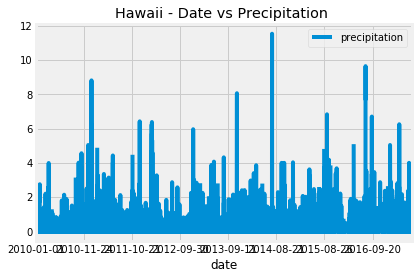

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_data_df.plot(x="date",y="precipitation",kind="line",ax=None,legend=True,
                    title="Hawaii - Date vs Precipitation ")
plt.savefig("datevsprecip2.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_data_df.describe()

,precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [14]:
# Design a query to show how many stations are available in this dataset?
# station_data = session.query(Station.station).all()  
# station_count=session.query(func.count(Station.station)).all()
station_count = session.query(Measurement.station).distinct().count()

print(station_count)
                

9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count_desc = session.query(Measurement.station,func.count(Measurement.station).label("station_count")).\
                    group_by(Measurement.station).\
                    order_by(desc("station_count")).\
                    all()
station_count_desc    
 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
(station_max,count_max) = station_count_desc[0]
print(station_max,count_max)

USC00519281 2772


In [17]:
station_temp_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == station_max).all()

station_temp_stats


[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(Measurement.date, Measurement.tobs).\
                     filter(Measurement.date > last_year).\
                     filter(Measurement.station ==  station_max).\
                     all()
station_temps[0:5]

[('2010-01-01', 70.0),
 ('2010-01-02', 62.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 75.0),
 ('2010-01-05', 74.0)]

In [19]:
station_temp_df = pd.DataFrame(station_temps, columns=['date','tobs'])
station_temp_df = station_temp_df.sort_values('date')
# station_temp_df.set_index(station_temp_df['date'], inplace = True)
station_temp_df.head()

,date,tobs
0,2010-01-01,70.0
1,2010-01-02,62.0
2,2010-01-03,74.0
3,2010-01-04,75.0
4,2010-01-05,74.0


In [20]:
temp_list = session.query(Measurement.tobs).\
                     filter(Measurement.date > last_year).\
                     filter(Measurement.station ==  station_max).\
                     all()

In [21]:
temp_list[1:5]

[(62.0), (74.0), (75.0), (74.0)]

In [22]:
temp_freq_dict={"Temperature":temp_list }
temp_freq_df=pd.DataFrame(temp_freq_dict)
temp_freq_df.tail(2)

,Temperature
2770,"(76.0,)"
2771,"(79.0,)"


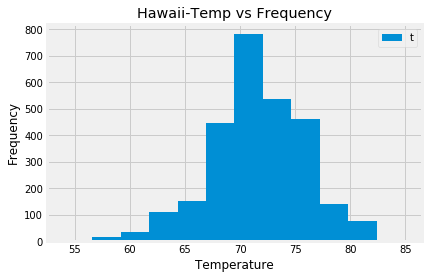

In [23]:
temp_array = temp_freq_df['Temperature'].tolist()
temp_array = [x[0] for x in temp_array]

plt.figure()
_, _ , _ = plt.hist(temp_array, bins=12)
plt.legend(("tobs"), loc="upper right")
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title('Hawaii-Temp vs Frequency')
plt.savefig("Temperature-vs-Frequency.png")
plt.show()   

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
tmam=calc_temps('2016-08-23','2017-08-23')
tmam


[(58.0, 74.59058295964125, 87.0)]

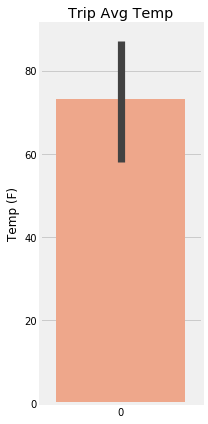

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
 

plt.figure(figsize=(3,6))
sns.barplot(data=tmam,color="lightsalmon")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')


# .plot()
plt.tight_layout()
plt.show()


In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 1.79),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.7),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 0.15),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  0.05),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  0.02),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, None)]

## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

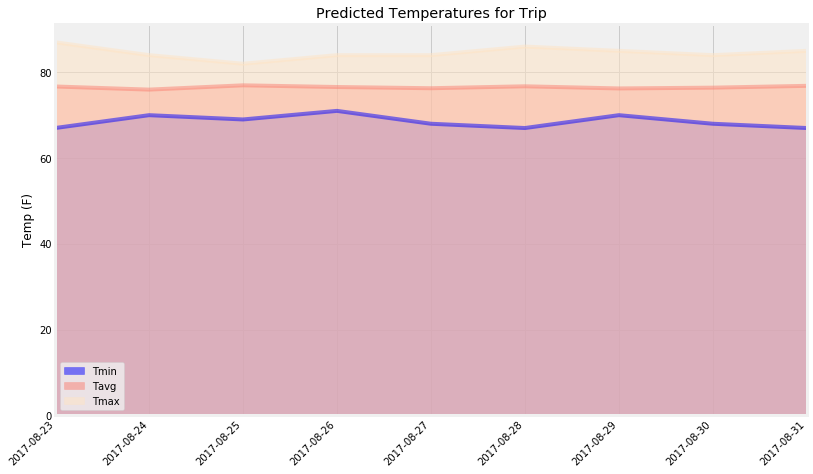

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# create a list of dates for your trip 

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

# create a list of dates for your trip 
trip_dates = pd.date_range(start_date, end_date)

# format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

# calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    # call daily_normals function to return the tuple list
    normals_list.append(*daily_normals(trip_date))

# make a normal df from the normals list
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
# make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

# Now plot the results 
# the colors list
colors = ['blue', 'salmon', 'bisque']

normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, title='Predicted Temperatures for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig("Predicted_Temperatures_for_Trip.png")
plt.show()

